## Creating a Marketing Pattern Sampler of Donor Datasets

1. Pattern Detection:
- Identifies key marketing narratives through regex patterns
- Categories cover physical, achievement, cultural, and personality aspects
- Flexible scoring system for content richness
2. Sampling Strategies
- Ensures representation across all marketing pattern categories
- Maintains demographic diversity
- Prioritizes profiles with rich descriptive content
3. Analysis Tools:
- Provides distribution analysis of patterns in sampled profiles
- Tracks ethnic distribution to ensure balanced representation
- Scores profiles based on content richness and pattern diversity


In [9]:
# Import required libraries
import json
import random
from typing import Dict, List, Tuple, Set
from collections import Counter
import os
from datetime import datetime
import re

class MarketingPatternSampler:
    def __init__(self):
        # Marketing pattern categories and their regex patterns
        self.MARKETING_PATTERNS = {
            'physical_description': {
                'height_emphasis': r'(standing tall|tall|6\'|6 foot)',
                'facial_features': r'(dimples|eyes|smile|high cheekbones)',
                'athletic_build': r'(athletic|fit|strong)'
            },
            'achievement_narratives': {
                'academic': r'(GPA|graduated|degree|scholar)',
                'professional': r'(career|professional|job|work)',
                'athletic': r'(athlete|sports|competition|champion)'
            },
            'cultural_framing': {
                'heritage': r'(background|descent|native|cultural)',
                'language': r'(speak|bilingual|fluent|languages)',
                'traditions': r'(tradition|heritage|roots|cultural)'
            },
            'personality_marketing': {
                'altruism': r'(help|caring|giving|volunteer)',
                'intelligence': r'(intelligent|smart|intellectual|bright)',
                'social': r'(friendly|outgoing|social|personable)'
            }
        }
        
    def analyze_marketing_patterns(self, profile: Dict) -> Set[str]:
        """Analyze a single profile for marketing patterns."""
        patterns_found = set()
        
        # Check if profile is None or not a dictionary
        if not profile or not isinstance(profile, dict):
            return patterns_found
            
        # Get description, return empty set if None or empty
        description = profile.get('donor_description')
        if not description:
            return patterns_found
            
        description = str(description).lower()
        
        for category, patterns in self.MARKETING_PATTERNS.items():
            for pattern_name, pattern in patterns.items():
                if re.search(pattern, description, re.IGNORECASE):
                    patterns_found.add(f"{category}_{pattern_name}")
        
        return patterns_found

    def score_profile_richness(self, profile: Dict) -> float:
        """Score profile based on content richness and pattern diversity."""
        # Check if profile is None or not a dictionary
        if not profile or not isinstance(profile, dict):
            return 0.0
            
        # Get description
        description = profile.get('donor_description', '')
        if not description:
            return 0.0
            
        patterns = self.analyze_marketing_patterns(profile)
        description_length = len(str(description))
        
        # Avoid division by zero
        if len(self.MARKETING_PATTERNS) == 0:
            return 0.0
            
        pattern_score = len(patterns) / len(self.MARKETING_PATTERNS)
        length_score = min(description_length / 500, 1.0)
        
        return (pattern_score * 0.7) + (length_score * 0.3)

    def sample_profiles(self, 
                       profiles: List[Dict], 
                       sample_size: int = 150,
                       min_patterns: int = 2) -> List[Dict]:
        """Sample profiles ensuring representation of marketing patterns."""
        # Check if profiles is None or empty
        if not profiles:
            return []
            
        scored_profiles = []
        for profile in profiles:
            if profile is None:
                continue
            patterns = self.analyze_marketing_patterns(profile)
            if len(patterns) >= min_patterns:
                score = self.score_profile_richness(profile)
                scored_profiles.append((score, profile, patterns))
        
        if not scored_profiles:
            return []
            
        scored_profiles.sort(key=lambda x: x[0], reverse=True)
        
        category_counts = {cat: 0 for cat in self.MARKETING_PATTERNS.keys()}
        selected_profiles = []
        
        target_per_category = sample_size / len(self.MARKETING_PATTERNS)
        
        for score, profile, patterns in scored_profiles:
            if len(selected_profiles) >= sample_size:
                break
                
            categories_present = set(pat.split('_')[0] for pat in patterns)
            
            if any(category_counts[cat] < target_per_category for cat in categories_present):
                selected_profiles.append(profile)
                for cat in categories_present:
                    category_counts[cat] += 1
        
        return selected_profiles

    def analyze_sample_distribution(self, sampled_profiles: List[Dict]) -> Dict:
        """Analyze the distribution of patterns in sampled profiles."""
        pattern_counts = {}
        ethnic_distribution = {}
        
        for profile in sampled_profiles:
            if profile is None:
                continue
                
            patterns = self.analyze_marketing_patterns(profile)
            for pattern in patterns:
                pattern_counts[pattern] = pattern_counts.get(pattern, 0) + 1
            
            ethnicity = profile.get('ethnic_background')
            if ethnicity:
                ethnic_distribution[ethnicity] = ethnic_distribution.get(ethnicity, 0) + 1
        
        return {
            'pattern_distribution': pattern_counts,
            'ethnic_distribution': ethnic_distribution
        }

## Define `DatasetSampler` and `sample_datasets function`

In [10]:
class DatasetSampler:
    def __init__(self, marketing_sampler: MarketingPatternSampler):
        self.marketing_sampler = marketing_sampler
        
    def calculate_ethnic_distribution(self, profiles: List[Dict]) -> Dict[str, float]:
        ethnicities = [p.get('ethnic_background') for p in profiles if p.get('ethnic_background')]
        total = len(ethnicities)
        if total == 0:
            return {}
        distribution = Counter(ethnicities)
        return {k: (v / total) for k, v in distribution.items()}

    def stratified_sample(self, 
                         profiles: List[Dict], 
                         sample_size: int,
                         maintain_ethnic_dist: bool = True) -> List[Dict]:
        """
        Create a stratified sample maintaining ethnic distribution and marketing patterns.
        """
        if maintain_ethnic_dist:
            ethnic_dist = self.calculate_ethnic_distribution(profiles)
            ethnic_targets = {k: int(v * sample_size) for k, v in ethnic_dist.items()}
        
        # Group profiles by ethnicity
        ethnic_groups = {}
        for profile in profiles:
            ethnicity = profile.get('ethnic_background')
            if ethnicity:
                if ethnicity not in ethnic_groups:
                    ethnic_groups[ethnicity] = []
                ethnic_groups[ethnicity].append(profile)
        
        sampled_profiles = []
        if maintain_ethnic_dist:
            for ethnicity, target_count in ethnic_targets.items():
                if ethnicity in ethnic_groups:
                    group_profiles = ethnic_groups[ethnicity]
                    # Score profiles in this ethnic group
                    scored_profiles = []
                    for p in group_profiles:
                        score = self.marketing_sampler.score_profile_richness(p)
                        scored_profiles.append((score, p))
                    
                    # Sort by score
                    scored_profiles.sort(key=lambda x: x[0], reverse=True)
                    
                    # Select profiles up to target count
                    selected = [p for _, p in scored_profiles[:target_count]]
                    sampled_profiles.extend(selected)
        else:
            sampled_profiles = self.marketing_sampler.sample_profiles(profiles, sample_size)
        
        # If we haven't met our sample size, add more profiles
        remaining = sample_size - len(sampled_profiles)
        if remaining > 0:
            # Get all unused profiles
            used_ids = {p.get('id', str(i)) for i, p in enumerate(sampled_profiles)}
            unused = []
            for i, p in enumerate(profiles):
                if p.get('id', str(i)) not in used_ids:
                    unused.append(p)
                    
            # Score and sort remaining profiles
            scored_remaining = []
            for p in unused:
                score = self.marketing_sampler.score_profile_richness(p)
                scored_remaining.append((score, p))
            
            scored_remaining.sort(key=lambda x: x[0], reverse=True)
            additional = [p for _, p in scored_remaining[:remaining]]
            sampled_profiles.extend(additional)
        
        return sampled_profiles

    def create_samples(self,
                      original_data: List[Dict],
                      augmented_data: List[Dict],
                      sample_size: int = 250,
                      output_dir: str = 'sampled_datasets') -> Tuple[List[Dict], List[Dict]]:
        """
        Create samples from both original and augmented datasets.
        """
        # Create samples
        original_sample = self.stratified_sample(original_data, sample_size)
        augmented_sample = self.stratified_sample(augmented_data, sample_size)
        
        # Create output directory if it doesn't exist
        os.makedirs(output_dir, exist_ok=True)
        
        # Generate timestamp for filenames
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        
        # Save samples
        original_file = f'{output_dir}/original_sample_{timestamp}.json'
        augmented_file = f'{output_dir}/augmented_sample_{timestamp}.json'
        
        with open(original_file, 'w') as f:
            json.dump(original_sample, f, indent=2)
        
        with open(augmented_file, 'w') as f:
            json.dump(augmented_sample, f, indent=2)
        
        # Create analysis report
        analysis = {
            'timestamp': timestamp,
            'sample_size': sample_size,
            'original_sample': {
                'ethnic_distribution': self.calculate_ethnic_distribution(original_sample),
                'marketing_patterns': self.marketing_sampler.analyze_sample_distribution(original_sample)
            },
            'augmented_sample': {
                'ethnic_distribution': self.calculate_ethnic_distribution(augmented_sample),
                'marketing_patterns': self.marketing_sampler.analyze_sample_distribution(augmented_sample)
            }
        }
        
        analysis_file = f'{output_dir}/analysis_report_{timestamp}.json'
        with open(analysis_file, 'w') as f:
            json.dump(analysis, f, indent=2)
        
        return original_sample, augmented_sample


def sample_datasets(original_path: str, 
                   augmented_path: str, 
                   sample_size: int = 250,
                   output_dir: str = 'sampled_datasets'):
    """
    Main function to sample both datasets.
    """
    # Initialize samplers
    marketing_sampler = MarketingPatternSampler()
    dataset_sampler = DatasetSampler(marketing_sampler)
    
    # Load datasets
    with open(original_path, 'r') as f:
        original_data = json.load(f)
    
    with open(augmented_path, 'r') as f:
        augmented_data = json.load(f)
    
    # Create samples
    original_sample, augmented_sample = dataset_sampler.create_samples(
        original_data,
        augmented_data,
        sample_size,
        output_dir
    )
    
    print(f"Created samples with {len(original_sample)} original and {len(augmented_sample)} augmented profiles")
    print(f"Files saved in {output_dir}")
    
    return original_sample, augmented_sample

## Run the Sampling

In [11]:
# Initialize and run sampling
original_sample, augmented_sample = sample_datasets(
    original_path='/Users/cindylinsf/Documents/CCI/THESIS/Msc_Thesis_Project_Files/data/processed/merged_donor_data.json',
    augmented_path='/Users/cindylinsf/Documents/CCI/THESIS/Msc_Thesis_Project_Files/data/generated/augmented_dataset/augmented_dataset.json',
    sample_size=250,
    output_dir='/Users/cindylinsf/Documents/CCI/THESIS/Msc_Thesis_Project_Files/data/sampled'
)

Created samples with 250 original and 250 augmented profiles
Files saved in /Users/cindylinsf/Documents/CCI/THESIS/Msc_Thesis_Project_Files/data/sampled


In [12]:
# Debug cell - run this after loading the data but before sampling
def inspect_data(data, label):
    print(f"\n=== Inspecting {label} dataset ===")
    print(f"Total records: {len(data)}")
    print("\nSample of first record:")
    if data:
        first_record = data[0]
        for key, value in first_record.items():
            print(f"{key}: {type(value)} - {value}")
    
    # Count records with missing descriptions
    missing_desc = sum(1 for p in data if not p.get('donor_description'))
    print(f"\nRecords with missing descriptions: {missing_desc}")

# Load and inspect the data
with open('/Users/cindylinsf/Documents/CCI/THESIS/Msc_Thesis_Project_Files/data/processed/merged_donor_data.json', 'r') as f:
    original_data = json.load(f)
    inspect_data(original_data, "Original")

with open('/Users/cindylinsf/Documents/CCI/THESIS/Msc_Thesis_Project_Files/data/generated/augmented_dataset/augmented_dataset.json', 'r') as f:
    augmented_data = json.load(f)
    inspect_data(augmented_data, "Augmented")


=== Inspecting Original dataset ===
Total records: 1019

Sample of first record:
donor_description: <class 'str'> - Doctor & Baker. always goes out of his way to do the right thing and help others, especially with their health. You might say that’s why he’s so dedicated to earning his degree as a Doctor of Pharmacy (3.99 GPA). Outside of his professional life, he enjoys many fascinating hobbies: learning to play the harmonium, gardening, and classic literature. With wavy, dark hair, this handsome donor also shows he cares by cooking and baking for others — skills he learned from his mother and grandmother.
height: <class 'str'> - 5'9 (175cm)
weight: <class 'str'> - 173 lbs (78kg)
eye_color: <class 'str'> - Brown
hair_color: <class 'str'> - Dark Brown
skin_tone: <class 'NoneType'> - None
education_level: <class 'str'> - Postgraduate
education_field: <class 'str'> - Pharmacy
ethnic_background: <class 'str'> - East Indian
religion: <class 'str'> - Hindu
occupation: <class 'NoneType'> - N

In the previous cell, we inspected the datasets:

Original Dataset:
-1,019 total records
-Only 11 missing descriptions
-Consistent structure with expected fields


Augmented Dataset:
- 1,014 total records
- No missing descriptions
- Same field structure plus a 'source' field
- Appears to maintain the same format as original

Next, we proceed with the sampling.

In [13]:
# Initialize and run sampling
original_sample, augmented_sample = sample_datasets(
    original_path='/Users/cindylinsf/Documents/CCI/THESIS/Msc_Thesis_Project_Files/data/processed/merged_donor_data.json',
    augmented_path='/Users/cindylinsf/Documents/CCI/THESIS/Msc_Thesis_Project_Files/data/generated/augmented_dataset/augmented_dataset.json',
    sample_size=250,
    output_dir='/Users/cindylinsf/Documents/CCI/THESIS/Msc_Thesis_Project_Files/data/sampled'
)

Created samples with 250 original and 250 augmented profiles
Files saved in /Users/cindylinsf/Documents/CCI/THESIS/Msc_Thesis_Project_Files/data/sampled


## Data Visualization

In [20]:
!pip install nbformat --upgrade
!pip install plotly
!pip install ipywidgets

  Using cached nbformat-5.10.4-py3-none-any.whl.metadata (3.6 kB)
Using cached nbformat-5.10.4-py3-none-any.whl (78 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.5/88.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.2/321.2 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 18.8 MB/s eta 0:00:00a 0:00:01


In [21]:
# Check installed versions
import nbformat
import plotly
print(f"nbformat version: {nbformat.__version__}")
print(f"plotly version: {plotly.__version__}")

nbformat version: 5.10.4
plotly version: 5.24.1


In [23]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np
# Initialize plotly for notebook
import plotly.io as pio
pio.renderers.default = "notebook"

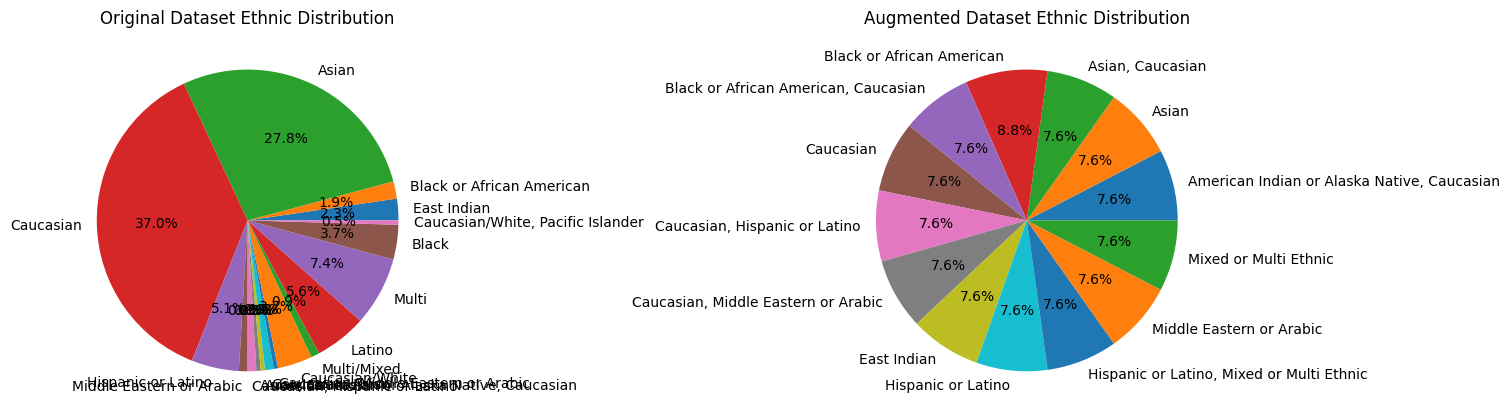

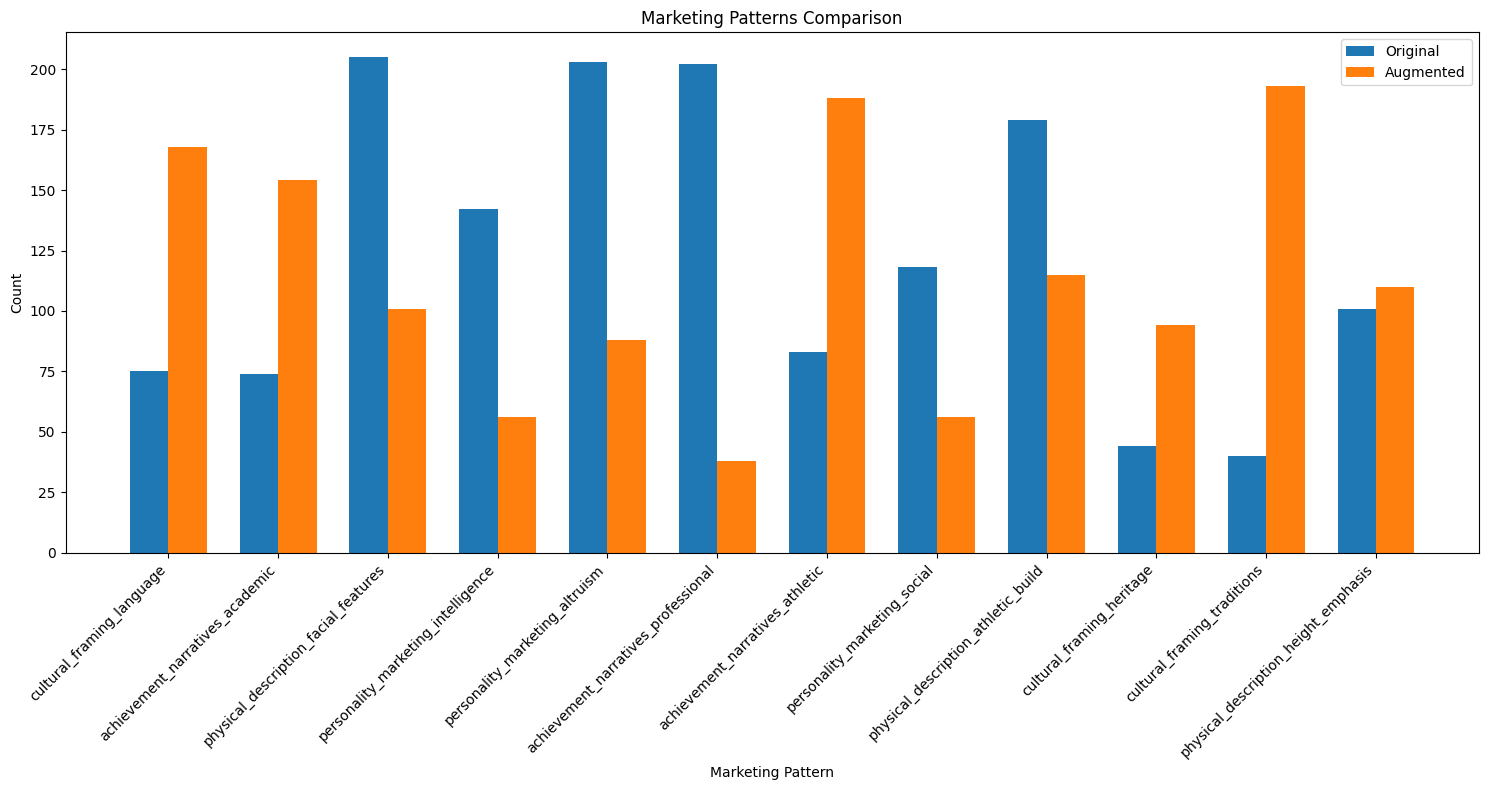

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_ethnic_distribution(analysis_data):
    # Create DataFrames for ethnic distribution
    original_ethnic = pd.DataFrame([
        {'Ethnicity': k, 'Percentage': v * 100, 'Dataset': 'Original'}
        for k, v in analysis_data['original_sample']['ethnic_distribution'].items()
        if not k.startswith('Mother:')
    ])
    
    augmented_ethnic = pd.DataFrame([
        {'Ethnicity': k, 'Percentage': v * 100, 'Dataset': 'Augmented'}
        for k, v in analysis_data['augmented_sample']['ethnic_distribution'].items()
    ])
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    
    # Plot original data
    ax1.pie(original_ethnic['Percentage'], labels=original_ethnic['Ethnicity'], autopct='%1.1f%%')
    ax1.set_title('Original Dataset Ethnic Distribution')
    
    # Plot augmented data
    ax2.pie(augmented_ethnic['Percentage'], labels=augmented_ethnic['Ethnicity'], autopct='%1.1f%%')
    ax2.set_title('Augmented Dataset Ethnic Distribution')
    
    plt.tight_layout()
    plt.show()

def plot_marketing_patterns(analysis_data):
    # Extract pattern distributions
    orig_patterns = analysis_data['original_sample']['marketing_patterns']['pattern_distribution']
    aug_patterns = analysis_data['augmented_sample']['marketing_patterns']['pattern_distribution']
    
    # Create DataFrame
    patterns_df = pd.DataFrame({
        'Pattern': list(orig_patterns.keys()),
        'Original': list(orig_patterns.values()),
        'Augmented': list(aug_patterns.values())
    })
    
    # Create bar plot
    plt.figure(figsize=(15, 8))
    x = np.arange(len(patterns_df['Pattern']))
    width = 0.35
    
    plt.bar(x - width/2, patterns_df['Original'], width, label='Original')
    plt.bar(x + width/2, patterns_df['Augmented'], width, label='Augmented')
    
    plt.xlabel('Marketing Pattern')
    plt.ylabel('Count')
    plt.title('Marketing Patterns Comparison')
    plt.xticks(x, patterns_df['Pattern'], rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Load and plot
import json

# Load the data
with open('/Users/cindylinsf/Documents/CCI/THESIS/Msc_Thesis_Project_Files/data/sampled/sampled_datasets/analysis_report_20241111_231039.json', 'r') as f:
    analysis_data = json.load(f)

# Create plots
plot_ethnic_distribution(analysis_data)
plot_marketing_patterns(analysis_data)